In [3]:
# First we set up some basic dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import qiskit as qis
import qiskit.pulse as qisp
from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit import IBMQ
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.compiler.assembler import MeasLevel, MeasReturnType
from qiskit.tools.monitor import job_monitor

if not IBMQ.active_account():
    IBMQ.load_account()
    
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

In [43]:
# Some helper functions

from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

def baselineRemover(values):
    return np.array(values) - np.mean(values)

def rabiExecute(backend,
            qubit,
            drive_freq,
            drive_dur,
            drive_sigma,
            drive_amps,
            drive_beta,
            num_shots):
    # Rabi drive instruction
    drive_amp = Parameter('drive_amp')
    with qisp.build(backend=backend, default_alignment='sequential') as rabiSched:
        qisp.set_frequency(drive_freq, qisp.drive_channel(0))
        qisp.play(qisp.Drag(duration=drive_dur,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              beta=drive_beta), qisp.drive_channel(0))
    
    # Init quantum circuit
    rabiGate = Gate("Rabi", 1, [drive_amp])
    qc_rabi = QuantumCircuit(1, 1)
    qc_rabi.append(rabiGate, [0])
    qc_rabi.measure(0, 0)
    qc_rabi.add_calibration(rabiGate, (0,), rabiSched, [drive_amp])
    exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]
    
    # Job assemble and run
    rabi_job = backend.run(exp_rabi_circs, 
                  meas_level=MeasLevel.KERNELED, 
                  meas_return=MeasReturnType.AVERAGE, 
                  shots=num_shots)
    
    return rabi_job

def rabiResultRetrieve(qubit, job, scale_factor, drive_amps):
    num_rabi_points = len(drive_amps)
    rabi_results = job.result(timeout=120)
    rabi_values = []
    for i in range(num_rabi_points):
        rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)
    rabi_values = np.real(baselineRemover(rabi_values))
    
    return rabi_values
    
def rabiFitting(drive_amps, rabi_values):
    fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [2, 0, 0.2, 0])
    drive_period = fit_params[2]
    return y_fit, drive_period

In [45]:
qubit = 0
drive_freq = backend.configuration().hamiltonian['vars'][f'wq{qubit}']/(2*np.pi)
# drive_coupling = backend.configuration().hamiltonian['vars'][f'omegad{qubit}']

x_sigma = 80
x_duration = 320

# num_rabi_cycles = 3
# amp_max = num_rabi_cycles * (np.sqrt(2*np.pi)/(x90_sigma * backend.configuration().dt))/drive_coupling
# amp_max_norm = min(amp_max, 1.0)

drive_amps = np.linspace(-0.1, 0.1, 51)
drive_beta = 0 # non-calibrated leakage

In [46]:
rabiJob = None 

if rabiJob is None:
    rabiJob = rabiExecute(
        backend=backend,
        qubit=qubit,
        drive_freq=drive_freq,
        drive_dur=x_duration,
        drive_sigma=x_sigma,
        drive_amps=drive_amps,
        drive_beta=drive_beta,
        num_shots = 2**14)
    print(rabiJob.job_id())
    job_monitor(rabiJob)

633c2b207f697b35ec64837b
Job Status: job has successfully run


In [40]:
# rabiJob = backend.retrieve_job('633bbf8f1b246c356972ca5b')

In [48]:
rabi_result = rabiResultRetrieve(qubit=0, job=rabiJob, scale_factor=1e-7, drive_amps=drive_amps)
rabi_fit = rabiFitting(drive_amps, rabi_result)
drive_period = rabi_fit[1]
pi_amp = abs(drive_period/2)

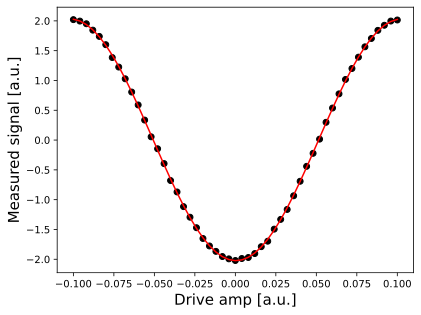

Updated Rabi amplitude is 0.10218341976411754


In [49]:
plt.scatter(drive_amps, rabi_result, color='black')
plt.plot(drive_amps, rabi_fit[0], color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()
print(f"Updated Rabi amplitude is {pi_amp}")